In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from typing import List, Dict, Optional
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

# Load Model Weights (may take a few minutes)

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = stable.tokenizer

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/home/evinpinar/miniconda3/envs/sd/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


# Pipeline Wrapper

In [4]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Run Inference on a Set of Seeds and Generate an Image Grid

In [5]:
def generate_images_for_method(prompt: str,
                               seeds: List[int],
                               indices_to_alter: Optional[List[int]] = None,
                               is_attend_and_excite: bool = True):
    token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None else indices_to_alter
    images = []
    for seed in seeds:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        run_standard_sd = False if is_attend_and_excite else True
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                generator=g,
                                run_standard_sd=run_standard_sd)
        images.append(image.resize((256, 256)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

# Stable Diffusion vs. Attend-and-Excite

## Stable Diffusion

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}
Altering tokens: ['cat', 'frog']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

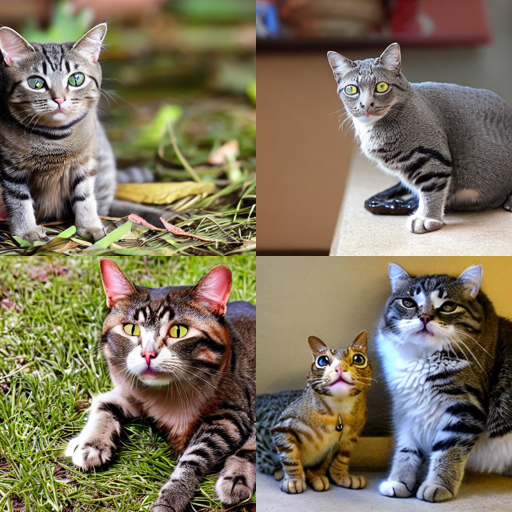

In [6]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}
Altering tokens: ['cat', 'frog']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0269
Iteration 1 | Loss: 0.0293
Iteration 2 | Loss: 0.0293
Iteration 3 | Loss: 0.0103
Iteration 4 | Loss: 0.0122
Iteration 5 | Loss: 0.0103
Iteration 6 | Loss: 0.0132
Iteration 7 | Loss: 0.0078
Iteration 8 | Loss: 0.0249
Iteration 9 | Loss: 0.0063
Iteration 10 | Loss: 0.0312
Iteration 11 | Loss: 0.0073
Iteration 12 | Loss: 0.0210
Iteration 13 | Loss: 0.0083
Iteration 14 | Loss: 0.0259
Iteration 15 | Loss: 0.0112
Iteration 16 | Loss: 0.0371
Iteration 17 | Loss: 0.0132
Iteration 18 | Loss: 0.0361
Iteration 19 | Loss: 0.0171
Iteration 20 | Loss: 0.0249
Iteration 21 | Loss: 0.0195
Iteration 22 | Loss: 0.0244
Iteration 23 | Loss: 0.0229
Iteration 24 | Loss: 0.0269


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0640
Iteration 1 | Loss: 0.0127
Iteration 2 | Loss: 0.0122
Iteration 3 | Loss: 0.0078
Iteration 4 | Loss: 0.0044
Iteration 5 | Loss: 0.0029
Iteration 6 | Loss: 0.0024
Iteration 7 | Loss: 0.0029
Iteration 8 | Loss: 0.0029
Iteration 9 | Loss: 0.0034
Iteration 10 | Loss: 0.0029
Iteration 11 | Loss: 0.0029
Iteration 12 | Loss: 0.0029
Iteration 13 | Loss: 0.0029
Iteration 14 | Loss: 0.0039
Iteration 15 | Loss: 0.0039
Iteration 16 | Loss: 0.0054
Iteration 17 | Loss: 0.0063
Iteration 18 | Loss: 0.0088
Iteration 19 | Loss: 0.0146
Iteration 20 | Loss: 0.0127
Iteration 21 | Loss: 0.0190
Iteration 22 | Loss: 0.0195
Iteration 23 | Loss: 0.0220
Iteration 24 | Loss: 0.0249


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1650
Iteration 1 | Loss: 0.1035
Iteration 2 | Loss: 0.1226
Iteration 3 | Loss: 0.0264
Iteration 4 | Loss: 0.0073
Iteration 5 | Loss: 0.0049
Iteration 6 | Loss: 0.0039
Iteration 7 | Loss: 0.0029
Iteration 8 | Loss: 0.0044
Iteration 9 | Loss: 0.0044
Iteration 10 | Loss: 0.0054
Iteration 11 | Loss: 0.0073
Iteration 12 | Loss: 0.0068
Iteration 13 | Loss: 0.0098
Iteration 14 | Loss: 0.0083
Iteration 15 | Loss: 0.0112
Iteration 16 | Loss: 0.0112
Iteration 17 | Loss: 0.0137
Iteration 18 | Loss: 0.0142
Iteration 19 | Loss: 0.0156
Iteration 20 | Loss: 0.0166
Iteration 21 | Loss: 0.0181
Iteration 22 | Loss: 0.0195
Iteration 23 | Loss: 0.0210
Iteration 24 | Loss: 0.0229


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0835
Iteration 1 | Loss: 0.0093
Iteration 2 | Loss: 0.0088
Iteration 3 | Loss: 0.0063
Iteration 4 | Loss: 0.0049
Iteration 5 | Loss: 0.0054
Iteration 6 | Loss: 0.0044
Iteration 7 | Loss: 0.0239
Iteration 8 | Loss: 0.0059
Iteration 9 | Loss: 0.0078
Iteration 10 | Loss: 0.0078
Iteration 11 | Loss: 0.0093
Iteration 12 | Loss: 0.0103
Iteration 13 | Loss: 0.0112
Iteration 14 | Loss: 0.0112
Iteration 15 | Loss: 0.0146
Iteration 16 | Loss: 0.0127
Iteration 17 | Loss: 0.0166
Iteration 18 | Loss: 0.0146
Iteration 19 | Loss: 0.0156
Iteration 20 | Loss: 0.0171
Iteration 21 | Loss: 0.0171
Iteration 22 | Loss: 0.0195
Iteration 23 | Loss: 0.0200
Iteration 24 | Loss: 0.0229


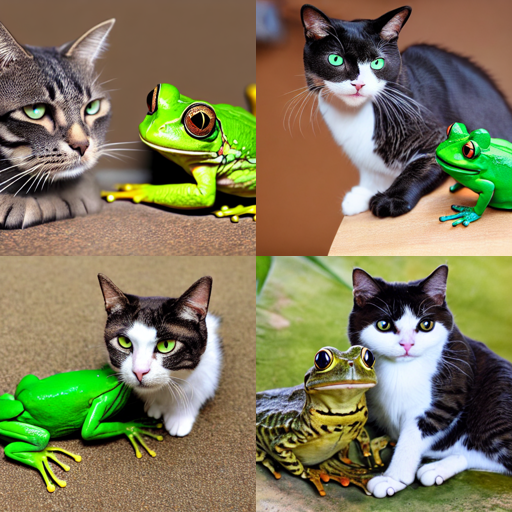

In [7]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=True
)

## Stable Diffusion

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Altering tokens: ['mouse', 'car']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

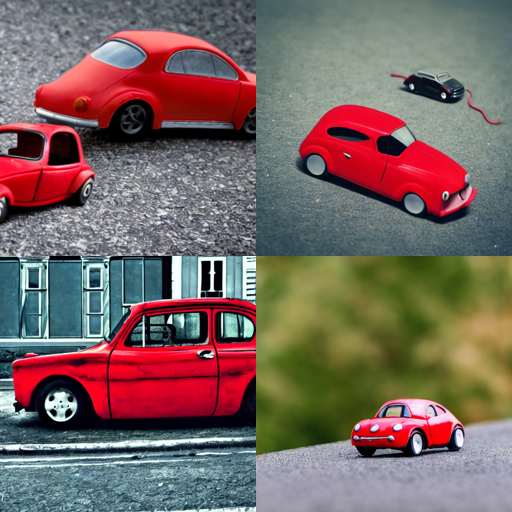

In [8]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Altering tokens: ['mouse', 'car']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8955
Iteration 1 | Loss: 0.0176
Iteration 2 | Loss: 0.0156
Iteration 3 | Loss: 0.0000
Iteration 4 | Loss: 0.0000
Iteration 5 | Loss: 0.0000
Iteration 6 | Loss: 0.0000
Iteration 7 | Loss: 0.0000
Iteration 8 | Loss: 0.0010
Iteration 9 | Loss: 0.0034
Iteration 10 | Loss: 0.0039
Iteration 11 | Loss: 0.0166
Iteration 12 | Loss: 0.0151
Iteration 13 | Loss: 0.0381
Iteration 14 | Loss: 0.0371
Iteration 15 | Loss: 0.0464
Iteration 16 | Loss: 0.0435
Iteration 17 | Loss: 0.0410
Iteration 18 | Loss: 0.0371
Iteration 19 | Loss: 0.0361
Iteration 20 | Loss: 0.0391
Iteration 21 | Loss: 0.0430
Iteration 22 | Loss: 0.0405
Iteration 23 | Loss: 0.0464
Iteration 24 | Loss: 0.0420


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8398
Iteration 1 | Loss: 0.0049
Iteration 2 | Loss: 0.0039
Iteration 3 | Loss: 0.0034
Iteration 4 | Loss: 0.0039
Iteration 5 | Loss: 0.0015
Iteration 6 | Loss: 0.0034
Iteration 7 | Loss: 0.0044
Iteration 8 | Loss: 0.0068
Iteration 9 | Loss: 0.0098
Iteration 10 | Loss: 0.0103
Iteration 11 | Loss: 0.0122
Iteration 12 | Loss: 0.0122
Iteration 13 | Loss: 0.0200
Iteration 14 | Loss: 0.0117
Iteration 15 | Loss: 0.0234
Iteration 16 | Loss: 0.0142
Iteration 17 | Loss: 0.0244
Iteration 18 | Loss: 0.0176
Iteration 19 | Loss: 0.0254
Iteration 20 | Loss: 0.0239
Iteration 21 | Loss: 0.0293
Iteration 22 | Loss: 0.0308
Iteration 23 | Loss: 0.0322
Iteration 24 | Loss: 0.0352


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8940
Iteration 1 | Loss: 0.6143
Iteration 2 | Loss: 0.5332
Iteration 3 | Loss: 0.1045
Iteration 4 | Loss: 0.0044
Iteration 5 | Loss: 0.0190
Iteration 6 | Loss: 0.0142
Iteration 7 | Loss: 0.0166
Iteration 8 | Loss: 0.0283
Iteration 9 | Loss: 0.0259
Iteration 10 | Loss: 0.0557
Iteration 11 | Loss: 0.0415
Iteration 12 | Loss: 0.0620
Iteration 13 | Loss: 0.0464
Iteration 14 | Loss: 0.0469
Iteration 15 | Loss: 0.0425
Iteration 16 | Loss: 0.0469
Iteration 17 | Loss: 0.0435
Iteration 18 | Loss: 0.0508
Iteration 19 | Loss: 0.0469
Iteration 20 | Loss: 0.0498
Iteration 21 | Loss: 0.0420
Iteration 22 | Loss: 0.0376
Iteration 23 | Loss: 0.0391
Iteration 24 | Loss: 0.0464


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.7271
Iteration 1 | Loss: 0.0229
Iteration 2 | Loss: 0.0195
Iteration 3 | Loss: 0.0059
Iteration 4 | Loss: 0.0107
Iteration 5 | Loss: 0.0151
Iteration 6 | Loss: 0.0234
Iteration 7 | Loss: 0.0210
Iteration 8 | Loss: 0.0352
Iteration 9 | Loss: 0.0234
Iteration 10 | Loss: 0.0420
Iteration 11 | Loss: 0.0322
Iteration 12 | Loss: 0.0415
Iteration 13 | Loss: 0.0664
Iteration 14 | Loss: 0.0591
Iteration 15 | Loss: 0.0830
Iteration 16 | Loss: 0.0674
Iteration 17 | Loss: 0.0830
Iteration 18 | Loss: 0.0674
Iteration 19 | Loss: 0.0747
Iteration 20 | Loss: 0.0493
Iteration 21 | Loss: 0.0620
Iteration 22 | Loss: 0.0410
Iteration 23 | Loss: 0.0542
Iteration 24 | Loss: 0.0371


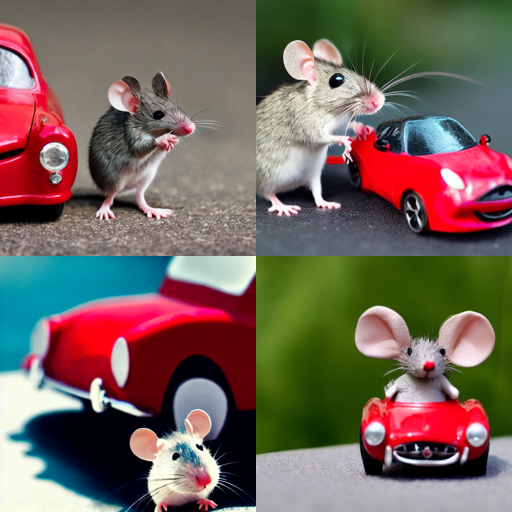

In [9]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=True
)